# Study case: the Ring-hydroxylating Dioxygenases

In [1]:
from protlearn import *

In [2]:
# Create data frame from raw data and clean it
msa_file = "pf00848-alignment.fasta"
metadata_file = "pf00848-metadata.tsv"
viz_params = {
    'plot': True,
    'save': True,
    'show': True
}
msa = MSA(msa_file=msa_file, metadata_file=metadata_file)
n_rows, n_columns = msa.shape
print(f"Data from {msa_file} contains {n_rows} sequences and {n_columns} columns")

Data from pf00848-alignment.fasta contains 9381 sequences and 1225 columns


self.dirty.shape after replacing specified characters with NaN: (9381, 1225)
self.clean.shape right after creating a copy of 'dirty' data as the 'clean' data: (9381, 1225)
min_rows: 8442
self.clean.shape after removing columns with NaN values above the threshold: (9381, 41)
self.clean.shape after removing rows with NaN values above the threshold: (7568, 41)


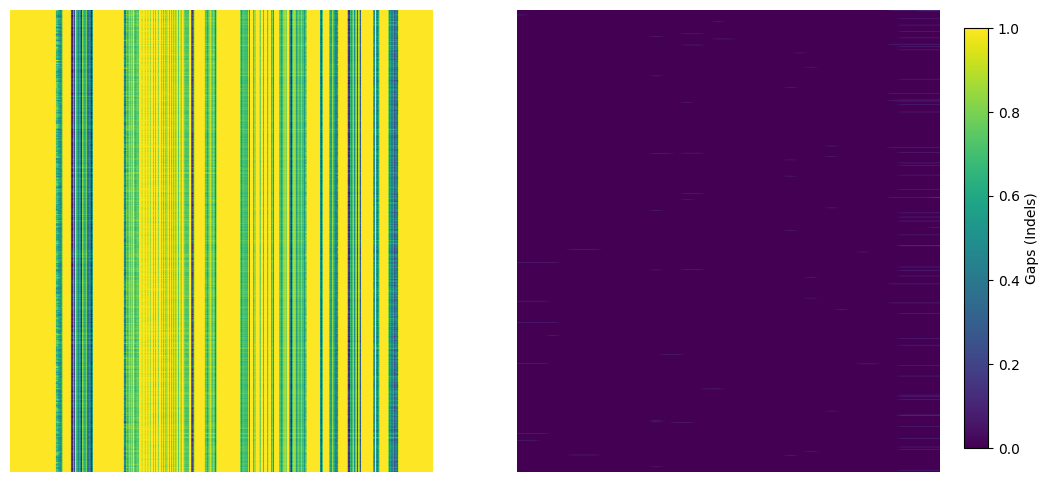

Before removing null values: (9381, 1225)
After removing null values: (7568, 41)
After removing duplicates: (6469, 41)


In [3]:
msa.cleanse(plot=True, show=True)
print(f"Before removing null values: {msa.dirty.shape}")
print(f"After removing null values: {msa.clean.shape}")
print(f"After removing duplicates: {msa.unique.shape}")

In [4]:
msa.reduce(n_components=2)
print(f"Dimensions reduced from {msa.unique.shape} to {msa.coordinates.shape}")

Dimensions reduced from (6469, 41) to (6469, 2)


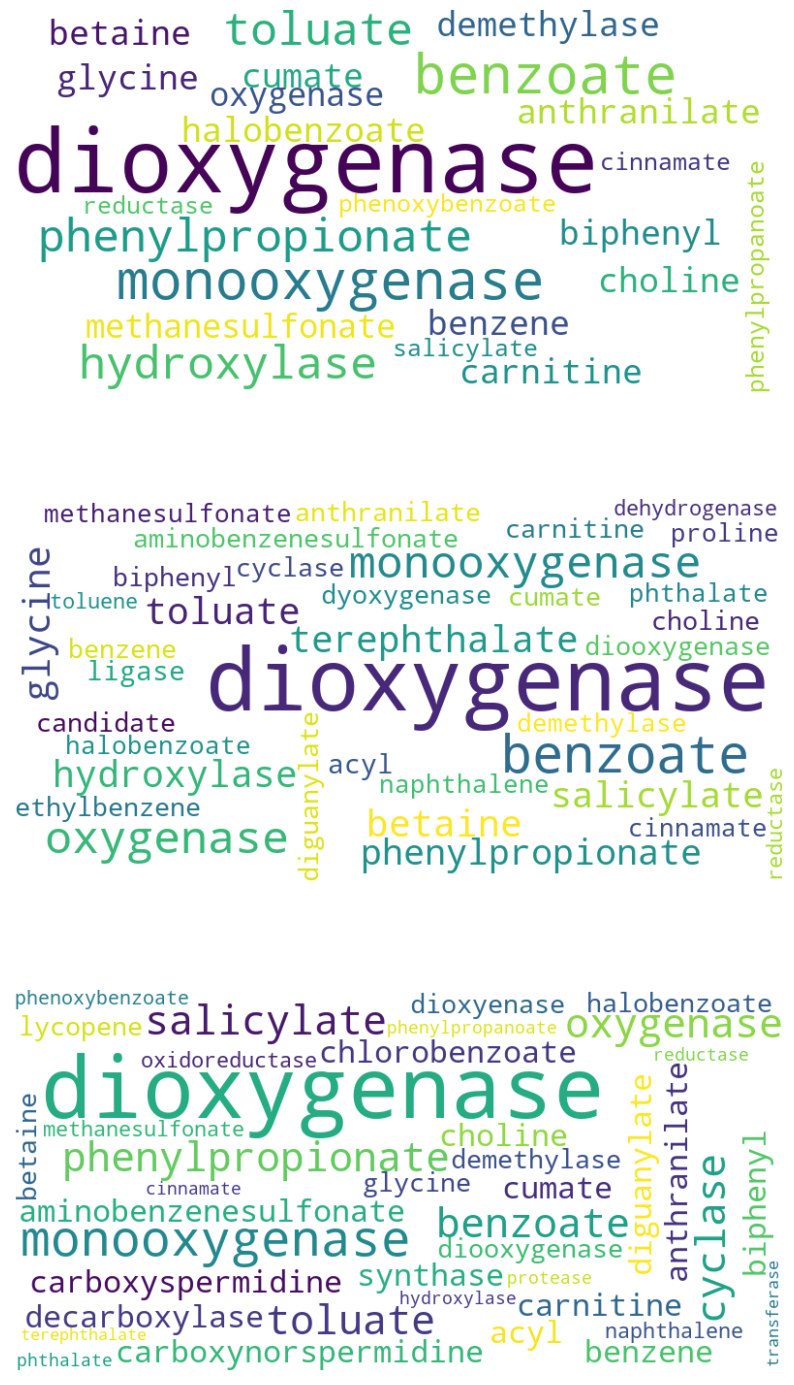

In [5]:
msa.cluster(min_clusters=3, **viz_params)

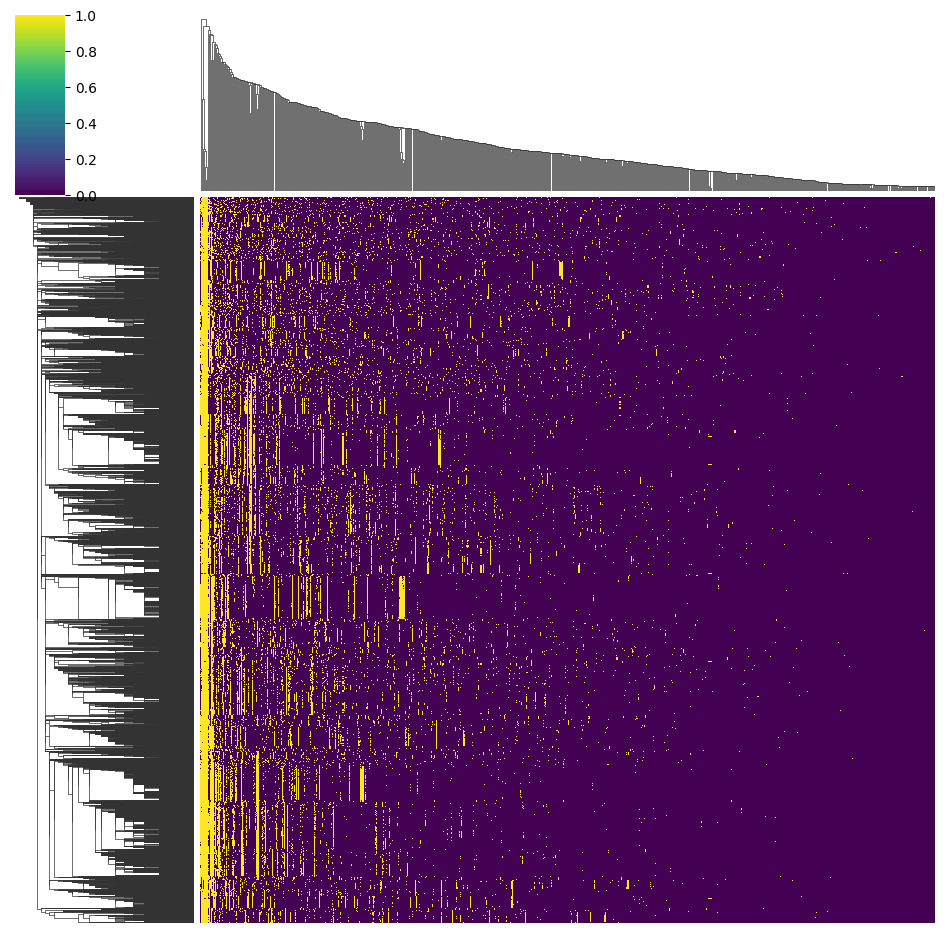

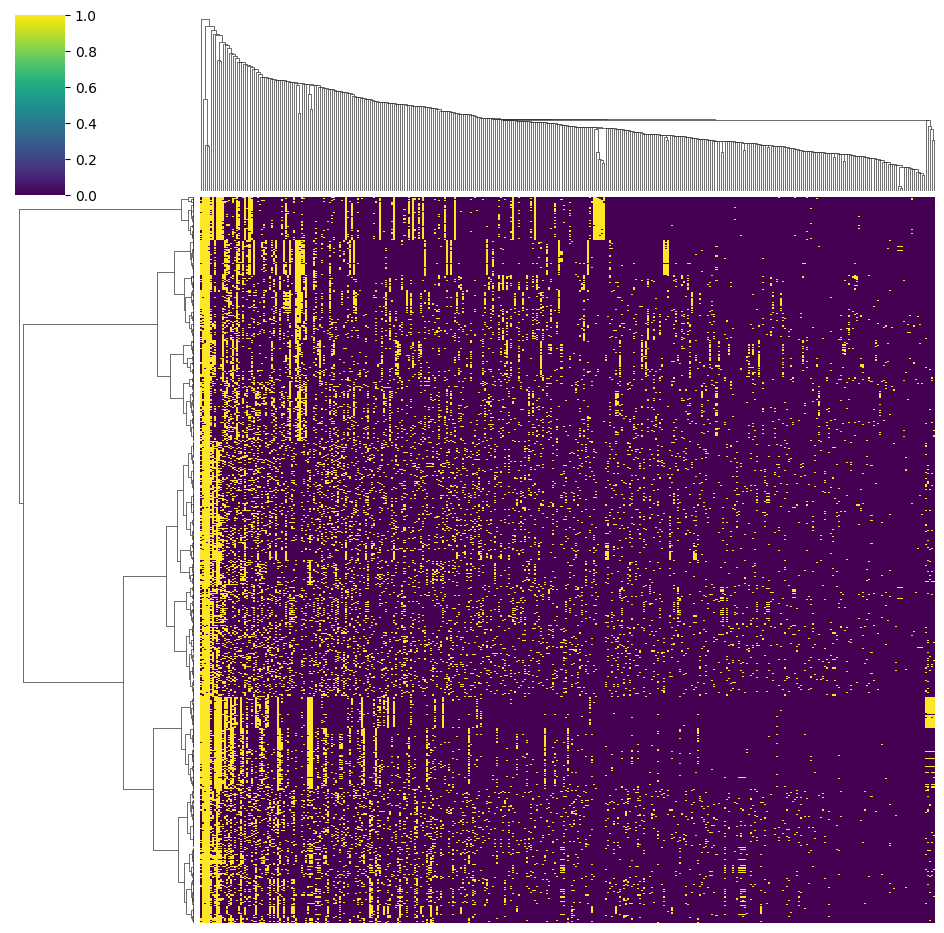

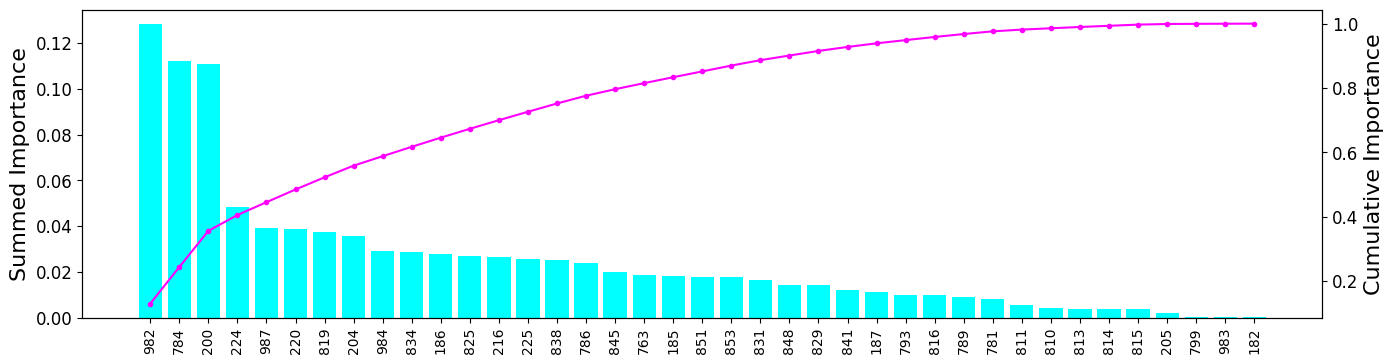

In [6]:
msa.select_features(n_estimators=1000, random_state=42, **viz_params)

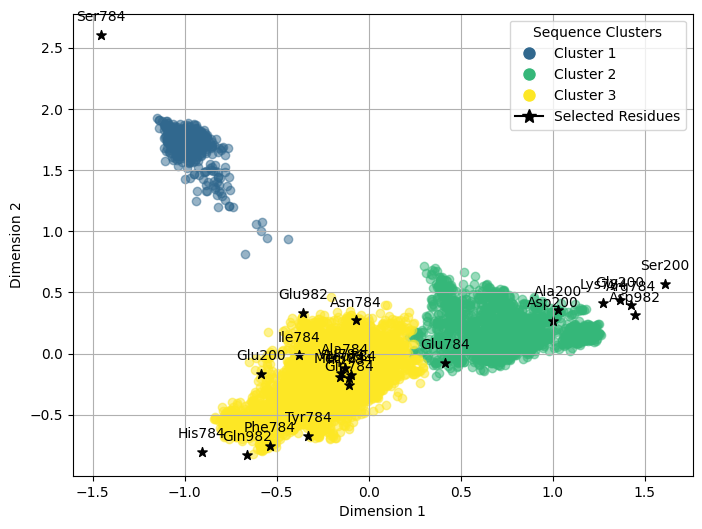

In [7]:
msa.select_residues(top_n=3, **viz_params)

## Manual steps:
**Attention!** The following snippets are not implemented in `protlearn` module. From here on, these are manual steps specific to this case study.

### Filter Sequences with Known Structures

The following code snippet filters sequences from the `msa.profiles` DataFrame based on whether their header contains a known structure from the `known_structure` [list](https://www.uniprot.org/uniprotkb?query=pf00848&facets=proteins_with%3A1%2Creviewed%3Atrue). Sequences with headers matching those in the `known_structure` list are retained in the filtered DataFrame.

In [8]:
known_structure = [
    'TPDA2_COMSP',
    'BPHA1_RHOJR',
    'NDOB_PSEU8',
    'NDOB_PSEPU',
    'NAGG_RALSP',
    'CNTA_ACIB2',
    'BNZA_PSEP1',
    'BPHA_PARXL',
    'BPHA_COMTE',
]
have_structure = []

# Iterate through headers and filter sequences with known structures
for header in msa.profiles.index:
    if header.split('/')[0] in known_structure:
        have_structure.append(header)

# Filter and display the sequences with known structures
filtered_sequences = msa.profiles[msa.profiles.index.isin(have_structure)]
filtered_sequences

,200,784,982
BPHA_PARXL/183-451,Ser229,Arg340,Asp387
BPHA1_RHOJR/174-441,Ser220,Arg330,Asp377


<a id="visualize-structure"></a>

### Visualize Protein Structure with Residue Highlights

In the following code, we use the `nglview` library to visualize a protein structure loaded from the Protein Data Bank (PDB). We load the PDB structure with the ID '1ULI,' which corresponds to 'BPHA1_RHOJR/174-441.'

In [9]:
import nglview as nv

# Load the PDB structure with the ID '1ULI' (correspondent to BPHA_PARXL/183-451).
pdb_id = '1ULI'
view = nv.show_pdbid(pdb_id)
view.update_representation(opacity=0.5)

# Define a list of selections for the residues you want to highlight in different chains
sdps, chains = (220, 330, 377), ('A', 'C', 'E')
selection_str = ":{} and ( {} or {} or {} )"

# Iterate over the selections and add representations one at a time
for chain in chains:
#     view.add_surface(selection_str.format(chain, *sdps), color='black')
    view.add_representation('ball+stick', selection=selection_str.format(chain, *sdps), color='black')
    view.add_representation('label', selection=selection_str.format(chain, *sdps), color='red')

# Display the updated structure
view

NGLWidget()